In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D, Activation, BatchNormalization, Flatten, InputLayer, Input, GlobalAveragePooling2D, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.models import load_model
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from keras.preprocessing import image
import random
from sklearn.utils import shuffle, class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, average_precision_score, confusion_matrix, precision_recall_curve, auc
from keras import backend as K
from keras.layers.core import Lambda
from keras.callbacks import ModelCheckpoint, TensorBoard
from itertools import combinations

Load the dataset

In [ ]:
def load_data():

      filenames = os.listdir('/content/drive/My Drive/CUHK01/')
      x = []
      labels = []

      j=0
      for filename in filenames:
        x += [cv2.imread(os.path.join(os.path.abspath('/content/drive/My Drive/CUHK01/'), filename), cv2.IMREAD_UNCHANGED)]
        labels += [int(filename[:4])]
        j +=1
        print(j)

      for i in range(len(x)):
        x[i] = cv2.resize(x[i], (128,128), interpolation=cv2.INTER_LINEAR).astype('uint8')
        print(i)

      return x, labels

In [ ]:
x, labels = load_data()

idx = np.argsort(labels)
x = np.array(x)[idx]
labels = np.array(labels)[idx]

In [ ]:
pickle_out = open("/content/drive/My Drive/Data/CUHK01/x.pickle","wb")
pickle.dump(x, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/labels.pickle","wb")
pickle.dump(labels, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/My Drive/Data/CUHK01/x.pickle","rb")
x = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/labels.pickle","rb")
labels = pickle.load(pickle_in)

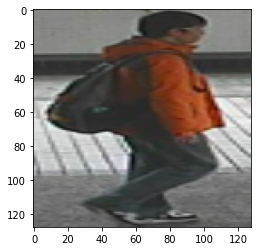

person 2


In [ ]:
plt.imshow(cv2.cvtColor(x[6], cv2.COLOR_BGR2RGB))
plt.show()
print('person', labels[6])

Train the MobileNet - Classification

In [ ]:
def base_model():

    mobilenet = keras.applications.mobilenet.MobileNet(input_shape=(128,128,3), weights="imagenet", include_top=False)

    model = Sequential()
    model.add(mobilenet)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(972, activation='softmax'))

    return model

In [ ]:
def train_valid_split(data,labels):
  
  x_train = []
  labels_train = []
  x_valid = []
  labels_valid = []

  for i in range(len(labels)):
    if i%4 == 0:
      x_valid += [data[i]]
      labels_valid += [labels[i]]
    else:
      x_train += [data[i]]
      labels_train += [labels[i]]

  x_train = np.array(x_train)
  labels_train = np.array(labels_train)
  x_valid = np.array(x_valid)
  labels_valid = np.array(labels_valid)

  return x_train, labels_train, x_valid, labels_valid


In [ ]:
labels = to_categorical(labels, num_classes=972)

In [ ]:
x_train, labels_train, x_valid, labels_valid = train_valid_split(x,labels)

aux = np.arange(labels_train.shape[0])
np.random.shuffle(aux)
x_train = x_train[aux]
labels_train = labels_train[aux]

aux = np.arange(labels_valid.shape[0])
np.random.shuffle(aux)
x_valid = x_valid[aux]
labels_valid = labels_valid[aux]

In [ ]:
model = base_model()
model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 972)               996300    
Total params: 6,324,364
Trainable params: 6,302,476
Non-t

In [ ]:
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

callbacks = ModelCheckpoint('/content/drive/My Drive/Results/MobileNet_Class_shuffle.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto')

results = model.fit(x_train, labels_train, batch_size=32, epochs=500, steps_per_epoch=50, callbacks = callbacks, validation_data=(x_valid, labels_valid))

Epoch 1/500
50/50 [==============================] - ETA: 0s - loss: 7.0882 - accuracy: 6.2500e-04
Epoch 00001: val_loss improved from inf to 6.94212, saving model to /content/drive/My Drive/Results/MobileNet_Class_shuffle.h5
50/50 [==============================] - 4s 77ms/step - loss: 7.0882 - accuracy: 6.2500e-04 - val_loss: 6.9421 - val_accuracy: 0.0010
Epoch 2/500
50/50 [==============================] - ETA: 0s - loss: 6.9784 - accuracy: 0.0032
Epoch 00002: val_loss improved from 6.94212 to 6.91018, saving model to /content/drive/My Drive/Results/MobileNet_Class_shuffle.h5
50/50 [==============================] - 4s 71ms/step - loss: 6.9784 - accuracy: 0.0032 - val_loss: 6.9102 - val_accuracy: 0.0010
Epoch 3/500
50/50 [==============================] - ETA: 0s - loss: 6.8045 - accuracy: 0.0025
Epoch 00003: val_loss improved from 6.91018 to 6.87179, saving model to /content/drive/My Drive/Results/MobileNet_Class_shuffle.h5
50/50 [==============================] - 3s 68ms/step - lo

In [ ]:
model = load_model('/content/drive/My Drive/Results/MobileNet_Class.h5')

predictions = []

for i in range(len(x_valid)):
  print(i)
  predictions.append(model.predict(np.expand_dims(x_valid[i], axis=0))[0])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [ ]:
labels_valid = labels_valid.tolist()

for i in range(len(predictions)):
  predictions[i] = np.argmax(predictions[i])
  labels_valid[i] = np.array(labels_valid[i])
  labels_valid[i] = np.argmax(labels_valid[i])

predictions = np.array(predictions)
labels_valid = np.array(labels_valid)

In [ ]:
print('Accuracy: %.3f' % accuracy_score(labels_valid, predictions))
#print('Precision: %.3f' % precision_score(labels_valid, predictions, average='micro'))
#print('Recall: %.3f' % recall_score(labels_valid, predictions, average='micro'))
#print('AP: %.3f' % average_precision_score(labels_valid, predictions))
#confusion_matrix(labels_valid, predictions)

Accuracy: 0.549


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


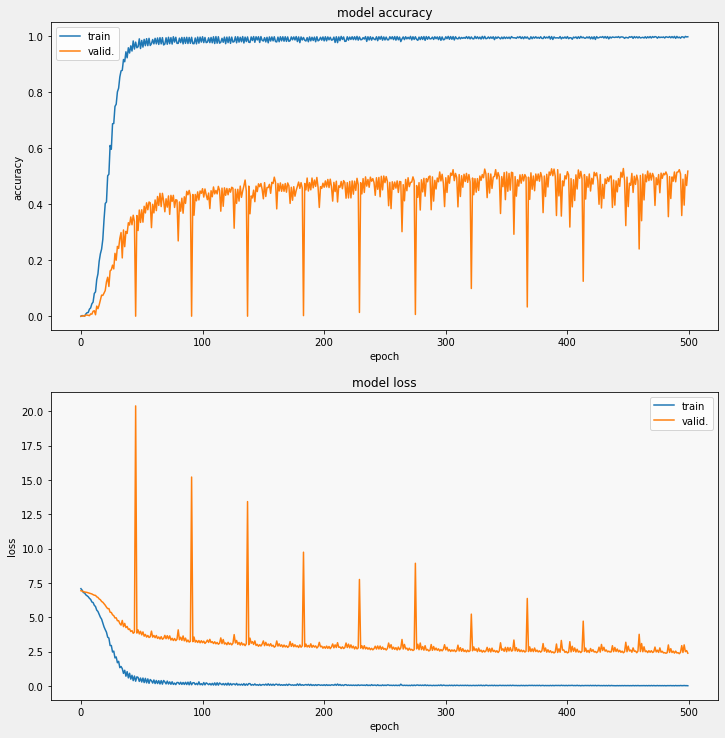

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])


print(results.history.keys())
display_training_curves(results.history['accuracy'], results.history['val_accuracy'], 'accuracy', 211)
display_training_curves(results.history['loss'], results.history['val_loss'], 'loss', 212)

-----------------RE-ID PART--------------------

In [ ]:
def divide_data_reid_open(x,labels):

  data_train = []
  labels_train = []

  data_valid = []
  labels_valid = []

  for i in range(len(labels)):
    if labels[i] < 681:
      data_train.append(x[i])
      labels_train.append(labels[i])
    else:
      data_valid.append(x[i])
      labels_valid.append(labels[i])

  data_train = np.array(data_train)
  data_valid = np.array(data_valid)
  labels_train = np.array(labels_train)
  labels_valid = np.array(labels_valid)

  return data_train, labels_train, data_valid, labels_valid

In [ ]:
def divide_data_reid_close(x,labels):

  data_train = []
  labels_train = []

  data_valid = []
  labels_valid = []

  for i in range(len(labels)):
    if i%2 == 0:
      data_train.append(x[i])
      labels_train.append(labels[i])
    else:
      data_valid.append(x[i])
      labels_valid.append(labels[i])
    

  data_train = np.array(data_train)
  data_valid = np.array(data_valid)
  labels_train = np.array(labels_train)
  labels_valid = np.array(labels_valid)

  return data_train, labels_train, data_valid, labels_valid

In [ ]:
def l1_distance(inputs):
    input1, input2 = inputs
    #print(input1.shape, input2.shape)
    output = K.abs(input1 - input2)
    #print(output.shape)
    return output


def l1_distance_output_shape(shapes):
    shape1, shape2 = shapes
    assert shape1 == shape2
    return (1,)

In [ ]:
def get_mobile_net(x):

	model = load_model('/content/drive/My Drive/Results/CUHK01/MobileNet_Class.h5')
	new_model = Model(model.input, model.layers[-3].output)
	
	new_model.summary()
	
	feature_vectors = []
	i=0
	for xi in x:
		feature_vectors.append(new_model.predict(np.expand_dims(xi, axis=0)))
		i+=1
		print(i)
	
	for j in range(len(feature_vectors)):
		feature_vectors[j] = feature_vectors[j][0]
	
	feature_vectors = np.array(feature_vectors)

	return feature_vectors

In [ ]:
feat_vect = get_mobile_net(x)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128_input (In [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_1.00_128 (Function (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1049600   
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
Total params: 5,328,064
Trainable params: 5,306,176
Non-trainable params: 21,888
_________________________________________________________________
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38


In [ ]:
pickle_out = open("/content/drive/My Drive/Data/CUHK01/feat_vect.pickle","wb")
pickle.dump(feat_vect, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/My Drive/Data/CUHK01/feat_vect.pickle","rb")
feat_vect = pickle.load(pickle_in)

In [ ]:
def siamese_model():
   
    input1 = Input(shape=(2048,))
    dense_layer = Dense(1024, activation='relu')(input1)
    dense_layer = Dense(512, activation='relu')(dense_layer)
    dense_layer = Dense(256, activation='relu')(dense_layer)    
    dense_layer = Dense(10, activation='relu')(dense_layer)
    output = Dense(1, activation='sigmoid')(dense_layer)

    return Model(inputs=input1, outputs=output)

def siamese_model_1024():
   
    input1 = Input(shape=(1024,))
    input2 = Input(shape=(1024,))
    distance = Lambda(l1_distance, output_shape=l1_distance_output_shape)([input1, input2])    
    dense_layer = Dense(1024, activation='relu')(distance)
    dense_layer = Dense(1024, activation='relu')(dense_layer)
    dense_layer = Dense(512, activation='relu')(dense_layer)
    dense_layer = Dense(256, activation='relu')(dense_layer)
    dense_layer = Dense(10, activation='relu')(dense_layer)
    output = Dense(1, activation='sigmoid')(dense_layer)

    return Model(inputs=[input1, input2], outputs=output)

In [ ]:
def create_pairs_(x, labels):

    input1 = []
    input2 = []
    pair_labels = []
    image1 = []
    image2 = []

    for i in range(len(x)):
      for j in range(len(x)):
        if i != j:
          if labels[i] == labels[j]:
            label = 1
          else:
            label = 0

          input1 += [x[i]]
          input2 += [x[j]]
          pair_labels += [label]
          image1 += [labels[i]]
          image2 += [labels[j]]

    c = list(zip(input1, input2, pair_labels, image1, image2))

    random.shuffle(c)

    input1, input2, pair_labels, image1, image2 = zip(*c)

    #number of pairs labeled with 1
    count=0
    for label in pair_labels:
      if label == 1:
        count+=1

    final_input1 = []
    final_input2 = []
    final_pair_labels = []
    final_image1 = []
    final_image2 = []

    zero_count = 0

    for i in range(len(pair_labels)):
      if pair_labels[i] == 1:
        for j in range(28):
          final_input1.append(input1[i])
          final_input2.append(input2[i])
          final_pair_labels.append(pair_labels[i])
          final_image1.append(image1[i])
          final_image2.append(image2[i])
      elif pair_labels[i] == 0 and zero_count < 28*count:
        final_input1.append(input1[i])
        final_input2.append(input2[i])
        final_pair_labels.append(pair_labels[i])
        final_image1.append(image1[i])
        final_image2.append(image2[i])
        zero_count += 1
      #if len(final_pair_labels) == count*2:
       # break

    final_input1 = np.array(final_input1)
    final_input2 = np.array(final_input2)
    final_pair_labels = np.array(final_pair_labels)
    final_image1 = np.array(final_image1)
    final_image2 = np.array(final_image2)

    return final_input1, final_input2, final_pair_labels, final_image1, final_image2

In [ ]:
# CREATE DATA FOR OPEN WORLD

data_train, labels_train, data_valid, labels_valid = divide_data_reid_open(feat_vect,labels)

i1_train, i2_train, pair_labels_train, image1_t, image2_t = create_pairs_(data_train, labels_train)
i1_valid, i2_valid, pair_labels_valid, image1_v, image2_v = create_pairs_(data_valid, labels_valid)

aux = np.arange(pair_labels_train.shape[0])
np.random.shuffle(aux)
i1_train = i1_train[aux]
i2_train = i2_train[aux]
pair_labels_train = pair_labels_train[aux]

aux = np.arange(pair_labels_valid.shape[0])
np.random.shuffle(aux)
i1_valid = i1_valid[aux]
i2_valid = i2_valid[aux]
pair_labels_valid = pair_labels_valid[aux]

i_train = []
i_valid = []

for i in range(len(i1_train)):
  i_train.append(np.concatenate((i1_train[i], i2_train[i]), axis=None))

for i in range(len(i1_valid)):
  i_valid.append(np.concatenate((i1_valid[i], i2_valid[i]), axis=None))

i_train = np.array(i_train)
i_valid = np.array(i_valid)

In [ ]:
# SAVE TRAIN AND VALID FOR OPEN-WORLD
pickle_out = open("/content/drive/My Drive/Data/CUHK01/i_train_open.pickle","wb")
pickle.dump(i_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/pair_labels_train_open.pickle","wb")
pickle.dump(pair_labels_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i1_train_open.pickle","wb")
pickle.dump(i1_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i2_train_open.pickle","wb")
pickle.dump(i2_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i_valid_open.pickle","wb")
pickle.dump(i_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/pair_labels_valid_open.pickle","wb")
pickle.dump(pair_labels_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i1_valid_open.pickle","wb")
pickle.dump(i1_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i2_valid_open.pickle","wb")
pickle.dump(i2_valid, pickle_out)
pickle_out.close()

In [ ]:
# GET DATA FOR OPEN WORLD

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i_train_open.pickle","rb")
i_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/pair_labels_train_open.pickle","rb")
pair_labels_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i1_train_open.pickle","rb")
i1_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i2_train_open.pickle","rb")
i2_train = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i_valid_open.pickle","rb")
i_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/pair_labels_valid_open.pickle","rb")
pair_labels_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i1_valid_open.pickle","rb")
i1_valid = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i2_valid_open.pickle","rb")
i2_valid = pickle.load(pickle_in)

In [ ]:
count=0
for label in pair_labels_valid:
  if label == 0:
    count+=1

count

97100

In [ ]:
# CREATE DATA FOR CLOSE WORLD
data_train, labels_train, data_valid, labels_valid = divide_data_reid_close(feat_vect,labels)
i1_train, i2_train, pair_labels_train, image1_t, image2_t = create_pairs_(data_train, labels_train)
i1_valid, i2_valid, pair_labels_valid, image1_v, image2_v = create_pairs_(data_valid, labels_valid)

aux = np.arange(pair_labels_train.shape[0])
np.random.shuffle(aux)
i1_train = i1_train[aux]
i2_train = i2_train[aux]
pair_labels_train = pair_labels_train[aux]

aux = np.arange(pair_labels_valid.shape[0])
np.random.shuffle(aux)
i1_valid = i1_valid[aux]
i2_valid = i2_valid[aux]
pair_labels_valid = pair_labels_valid[aux]

i_train = []
i_valid = []

for i in range(len(i1_train)):
  i_train.append(np.concatenate((i1_train[i], i2_train[i]), axis=None))

for i in range(len(i1_valid)):
  i_valid.append(np.concatenate((i1_valid[i], i2_valid[i]), axis=None))

i_train = np.array(i_train)
i_valid = np.array(i_valid)

In [ ]:
# SAVE TRAIN AND VALID FOR CLOSE-WORLD

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i_train_close.pickle","wb")
pickle.dump(i_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/pair_labels_train_close.pickle","wb")
pickle.dump(pair_labels_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i1_train_close.pickle","wb")
pickle.dump(i1_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i2_train_close.pickle","wb")
pickle.dump(i2_train, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i_valid_close.pickle","wb")
pickle.dump(i_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/pair_labels_valid_close.pickle","wb")
pickle.dump(pair_labels_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i1_valid_close.pickle","wb")
pickle.dump(i1_valid, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Data/CUHK01/i2_valid_close.pickle","wb")
pickle.dump(i2_valid, pickle_out)
pickle_out.close()

In [ ]:
# GET DATA FOR CLOSE WORLD

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i_train_close.pickle","rb")
i_train = pickle.load(pickle_in)

print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK01/pair_labels_train_close.pickle","rb")
pair_labels_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i1_train_close.pickle","rb")
i1_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i2_train_close.pickle","rb")
i2_train = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i_valid_close.pickle","rb")
i_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK01/pair_labels_valid_close.pickle","rb")
pair_labels_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i1_valid_close.pickle","rb")
i1_valid = pickle.load(pickle_in)
print('1')

pickle_in = open("/content/drive/My Drive/Data/CUHK01/i2_valid_close.pickle","rb")
i2_valid = pickle.load(pickle_in)

1
1
1
1
1
1
1


In [ ]:
i_train = i_train[:1942]
i1_train = i1_train[:1942]
i2_train = i2_train[:1942]
pair_labels_train = pair_labels_train[:1942]

i_valid = i_valid[:1942]
i1_valid = i1_valid[:1942]
i2_valid = i2_valid[:1942]
pair_labels_valid = pair_labels_valid[:1942]

In [ ]:
model = siamese_model()

lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=10000,
    decay_rate=0.9)

opt = keras.optimizers.SGD(learning_rate=lr_schedule)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics = ['accuracy'])

model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2048)]            0         
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                2570      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
Total params: 2,756,885
Trainable params: 2,756,885
Non-trainable params: 0
____________________________________________

In [ ]:
callbacks = ModelCheckpoint('/content/drive/My Drive/Results/CUHK01/open_reid_1024_final.h5', monitor='val_loss', verbose=2, save_best_only=True, save_weights_only=False, mode='auto')

In [ ]:
#2048 input
#reid_results = model.fit(i_train, pair_labels_train, batch_size=32, steps_per_epoch=20, epochs=200, verbose=2, validation_data=(i_valid, pair_labels_valid), callbacks=callbacks)

#1024 input
reid_results = model.fit([i1_train, i2_train], pair_labels_train, batch_size=32, steps_per_epoch=20, epochs=200, verbose=2, validation_data=([i1_valid, i2_valid], pair_labels_valid), callbacks=callbacks)

Epoch 1/200

Epoch 00001: val_loss improved from inf to 0.66469, saving model to /content/drive/My Drive/Results/CUHK01/open_reid_1024_final.h5
20/20 - 10s - loss: 0.6792 - accuracy: 0.5172 - val_loss: 0.6647 - val_accuracy: 0.5298
Epoch 2/200

Epoch 00002: val_loss improved from 0.66469 to 0.65287, saving model to /content/drive/My Drive/Results/CUHK01/open_reid_1024_final.h5
20/20 - 10s - loss: 0.6595 - accuracy: 0.5375 - val_loss: 0.6529 - val_accuracy: 0.5254
Epoch 3/200

Epoch 00003: val_loss improved from 0.65287 to 0.64285, saving model to /content/drive/My Drive/Results/CUHK01/open_reid_1024_final.h5
20/20 - 10s - loss: 0.6354 - accuracy: 0.5719 - val_loss: 0.6429 - val_accuracy: 0.5380
Epoch 4/200

Epoch 00004: val_loss improved from 0.64285 to 0.62677, saving model to /content/drive/My Drive/Results/CUHK01/open_reid_1024_final.h5
20/20 - 10s - loss: 0.6394 - accuracy: 0.5797 - val_loss: 0.6268 - val_accuracy: 0.6457
Epoch 5/200

Epoch 00005: val_loss improved from 0.62677 to 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


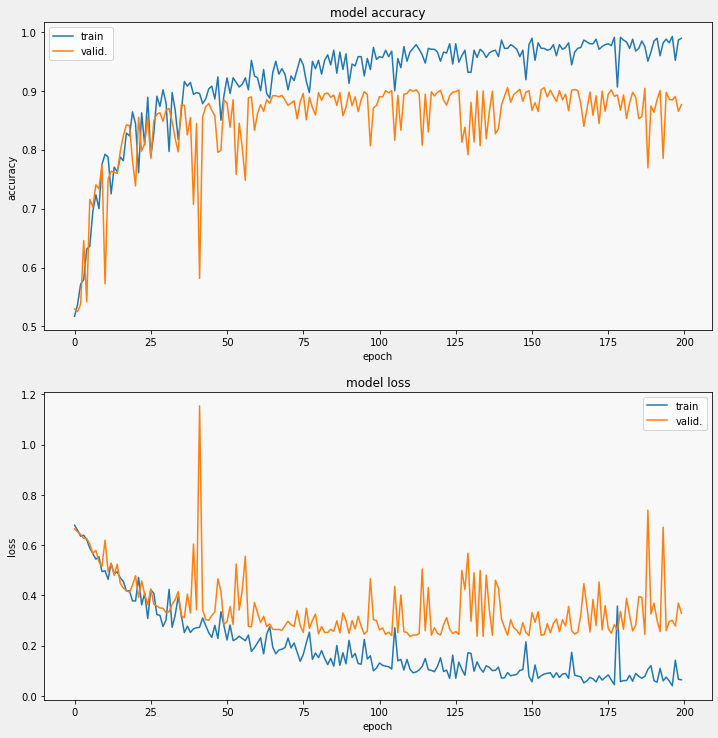

In [ ]:
def display_training_curves(training, validation, title, subplot):
  if subplot%10==1: # set up the subplots on the first call
    plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
    plt.tight_layout()
  ax = plt.subplot(subplot)
  ax.set_facecolor('#F8F8F8')
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['train', 'valid.'])


print(reid_results.history.keys())
display_training_curves(reid_results.history['accuracy'], reid_results.history['val_accuracy'], 'accuracy', 211)
display_training_curves(reid_results.history['loss'], reid_results.history['val_loss'], 'loss', 212)

Streaming output truncated to the last 5000 lines.
190553
190554
190555
190556
190557
190558
190559
190560
190561
190562
190563
190564
190565
190566
190567
190568
190569
190570
190571
190572
190573
190574
190575
190576
190577
190578
190579
190580
190581
190582
190583
190584
190585
190586
190587
190588
190589
190590
190591
190592
190593
190594
190595
190596
190597
190598
190599
190600
190601
190602
190603
190604
190605
190606
190607
190608
190609
190610
190611
190612
190613
190614
190615
190616
190617
190618
190619
190620
190621
190622
190623
190624
190625
190626
190627
190628
190629
190630
190631
190632
190633
190634
190635
190636
190637
190638
190639
190640
190641
190642
190643
190644
190645
190646
190647
190648
190649
190650
190651
190652
190653
190654
190655
190656
190657
190658
190659
190660
190661
190662
190663
190664
190665
190666
190667
190668
190669
190670
190671
190672
190673
190674
190675
190676
190677
190678
190679
190680
190681
190682
190683
190684
190685
190686
190687
1906

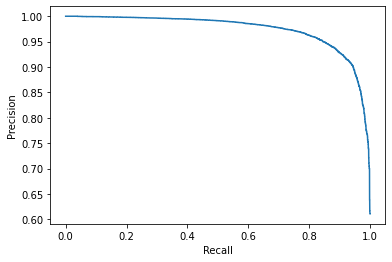

Accuracy: 0.918
Precision: 0.922
Recall: 0.913


array([[90258,  7518],
       [ 8512, 89264]])

In [ ]:
### mAP Precision vs Recall 2048 ###

model = load_model('/content/drive/My Drive/Results/CUHK01/open_reid_2048_final.h5')

labels_pred = []

for i in range(len(i_valid)):
  print(i)
  labels_pred.append(model.predict(np.expand_dims(i_valid[i], axis=0))[0][0])

labels_pred = np.array(labels_pred)

precision, recall, thresholds = precision_recall_curve(pair_labels_valid, labels_pred)

print(auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

for i in range(len(labels_pred)):
  if labels_pred[i] < 0.5:
    labels_pred[i] = 0
  else:
    labels_pred[i] = 1

labels_pred = np.array(labels_pred)

print('Accuracy: %.3f' % accuracy_score(pair_labels_valid, labels_pred))
print('Precision: %.3f' % precision_score(pair_labels_valid, labels_pred))
print('Recall: %.3f' % recall_score(pair_labels_valid, labels_pred))
confusion_matrix(pair_labels_valid, labels_pred)

0.9590673117197156


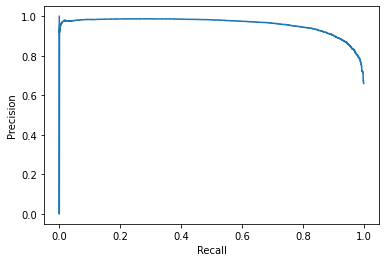

Accuracy: 0.902
Precision: 0.909
Recall: 0.893


array([[89006,  8770],
       [10416, 87360]])

In [ ]:
### mAP Precision vs Recall 1024 ###

model = load_model('/content/drive/My Drive/Results/CUHK01/open_reid_1024_final.h5')

cena1 = np.expand_dims(i1_valid, axis=0)
cena2 = np.expand_dims(i2_valid, axis=0)

labels_pred = model.predict([cena1, cena2])[0]

labels_pred = labels_pred.tolist()

for i in range(len(labels_pred)):
  labels_pred[i] = labels_pred[i][0]
    
labels_pred = np.array(labels_pred)

precision, recall, thresholds = precision_recall_curve(pair_labels_valid, labels_pred)

print(auc(recall, precision))

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

for i in range(len(labels_pred)):
  if labels_pred[i] < 0.5:
    labels_pred[i] = 0
  else:
    labels_pred[i] = 1

labels_pred = np.array(labels_pred)

print('Accuracy: %.3f' % accuracy_score(pair_labels_valid, labels_pred))
print('Precision: %.3f' % precision_score(pair_labels_valid, labels_pred))
print('Recall: %.3f' % recall_score(pair_labels_valid, labels_pred))
confusion_matrix(pair_labels_valid, labels_pred)

In [ ]:
query_list = []
gallery_list = []

x_classes = []
labels_classes = []

for j in range(1, 972):
  aux_x = []
  aux_labels = []
  for i in range(len(labels)):
    if labels[i] == j:
      aux_x.append(feat_vect[i])
      aux_labels.append(labels[i])
  x_classes.append(aux_x)
  labels_classes.append(aux_labels)

for i in range(971):
  rand = random.randint(0,3)
  gallery_list.append([labels_classes[i][rand], x_classes[i][rand]])

randomlist = random.sample(range(0, 971), 100)

for i in randomlist:
  rand = random.randint(0,3)
  query_list.append([labels_classes[i][rand], x_classes[i][rand]])

In [ ]:
def cmc_curve_2048(querys, gallery, topk):
    aux = 0
    ret = np.zeros(topk)
    valid_queries = 0
    all_rank = []
    sum_rank = np.zeros(topk)
    for query in querys:
        aux += 1
        print(aux)
        q_id = query[0]
        q_feature = query[1]
        # Calculate the distances for each query
        distmat = []
        for label, feature in gallery:
            #dist = np.linalg.norm(q_feature - feature)
            dist = model.predict(np.expand_dims(np.concatenate((q_feature, feature), axis=0), axis=0))
            distmat.append([dist, label])

        # Sort the results for each query
        distmat.sort(reverse=True)
        # Find matches
        matches = np.zeros(len(distmat))
        # Zero if no match 1 if match
        for i in range(0, len(distmat)):
            if distmat[i][1] == q_id:
                # Match found
                matches[i] = 1
        rank = np.zeros(topk)
        for i in range(0, topk):
            if matches[i] == 1:
                rank[i] = 1
                # If 1 is found then break as you dont need to look further path k
                break
        all_rank.append(rank)
        valid_queries +=1
    #print(all_rank)
    sum_all_ranks = np.zeros(len(all_rank[0]))
    for i in range(0,len(all_rank)):
        my_array = all_rank[i]
        for g in range(0, len(my_array)):
            sum_all_ranks[g] = sum_all_ranks[g] + my_array[g]
    sum_all_ranks = np.array(sum_all_ranks)
    print("NPSAR", sum_all_ranks)
    cmc_restuls = np.cumsum(sum_all_ranks) / valid_queries
    print(cmc_restuls)
    return cmc_restuls, sum_all_ranks


def cmc_curve_1024(querys, gallery, topk):
    aux = 0
    ret = np.zeros(topk)
    valid_queries = 0
    all_rank = []
    sum_rank = np.zeros(topk)
    for query in querys:
        aux += 1
        print(aux)
        q_id = query[0]
        q_feature = query[1]
        # Calculate the distances for each query
        distmat = []
        for label, feature in gallery:
            #dist = np.linalg.norm(q_feature - feature)
            dist = model.predict([np.expand_dims(q_feature, axis=0), np.expand_dims(feature, axis=0)])
            distmat.append([dist, label])

        # Sort the results for each query
        distmat.sort(reverse=True)
        # Find matches
        matches = np.zeros(len(distmat))
        # Zero if no match 1 if match
        for i in range(0, len(distmat)):
            if distmat[i][1] == q_id:
                # Match found
                matches[i] = 1
        rank = np.zeros(topk)
        for i in range(0, topk):
            if matches[i] == 1:
                rank[i] = 1
                # If 1 is found then break as you dont need to look further path k
                break
        all_rank.append(rank)
        valid_queries +=1
    #print(all_rank)
    sum_all_ranks = np.zeros(len(all_rank[0]))
    for i in range(0,len(all_rank)):
        my_array = all_rank[i]
        for g in range(0, len(my_array)):
            sum_all_ranks[g] = sum_all_ranks[g] + my_array[g]
    sum_all_ranks = np.array(sum_all_ranks)
    print("NPSAR", sum_all_ranks)
    cmc_restuls = np.cumsum(sum_all_ranks) / valid_queries
    print(cmc_restuls)
    return cmc_restuls, sum_all_ranks

In [ ]:
#Calculate mAP
def calculate_map(sum_ranks, n):
  sum = 0
  for i in range(len(sum_ranks)):
    sum += sum_ranks[i]/(i+1)
  map = (1/n)*sum
  print(map)

  return map

In [ ]:
model = load_model('/content/drive/My Drive/Results/CUHK01/open_reid_2048_final.h5')
cmc_re_2048, sum_ranks_2048 = cmc_curve_2048(query_list, gallery_list, len(gallery_list))
map_2048 = calculate_map(sum_ranks_2048, len(query_list))

model = load_model('/content/drive/My Drive/Results/CUHK01/open_reid_1024_final.h5')
cmc_re_1024, sum_ranks_1024 = cmc_curve_1024(query_list, gallery_list, len(gallery_list))
map_1024 = calculate_map(sum_ranks_1024, len(query_list))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
NPSAR [58.  6.  5.  2.  1.  7.  3.  1.  1.  1.  2.  1.  1.  0.  0.  1.  0.  1.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.
  1.  0.  0.  1.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.
  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

In [ ]:
pickle_out = open("/content/drive/My Drive/Results/CUHK01/cmc_re_open_2048.pickle","wb")
pickle.dump(cmc_re_2048, pickle_out)
pickle_out.close()

pickle_out = open("/content/drive/My Drive/Results/CUHK01/cmc_re_open_1024.pickle","wb")
pickle.dump(cmc_re_1024, pickle_out)
pickle_out.close()

In [ ]:
pickle_in = open("/content/drive/My Drive/Results/CUHK01/cmc_re_close_2048.pickle","rb")
cmc_re_2048 = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/CUHK01/cmc_re_close_1024.pickle","rb")
cmc_re_1024 = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/CUHK01/cmc_re_open_2048.pickle","rb")
cmc_re_2048_ = pickle.load(pickle_in)

pickle_in = open("/content/drive/My Drive/Results/CUHK01/cmc_re_open_1024.pickle","rb")
cmc_re_1024_ = pickle.load(pickle_in)

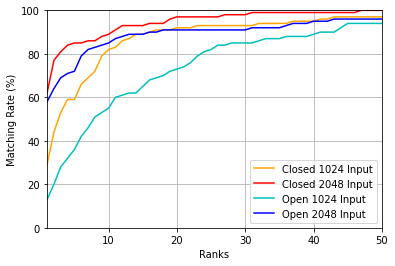

In [ ]:
cmc_re_2048 = cmc_re_2048[:50]
cmc_re_1024 = cmc_re_1024[:50]

cmc_re_2048_ = cmc_re_2048_[:50]
cmc_re_1024_ = cmc_re_1024_[:50]

ranks = [a for a in range(1,51)]

plt.plot(ranks, 100*cmc_re_1024, 'orange', label='Closed 1024 Input')
plt.plot(ranks, 100*cmc_re_2048, 'r', label='Closed 2048 Input')
plt.plot(ranks, 100*cmc_re_1024_, 'c', label='Open 1024 Input')
plt.plot(ranks, 100*cmc_re_2048_, 'b', label='Open 2048 Input')
plt.xlabel('Ranks')
plt.ylabel('Matching Rate (%)')
plt.axis([1, 50, 0, 100])
plt.grid()
plt.legend()
plt.show()

In [ ]:
model = load_model('/content/drive/My Drive/Results/CUHK01/close_reid_2048_final.h5')

In [ ]:
score = model.predict(np.expand_dims(np.concatenate((feat_vect[260], feat_vect[263]), axis = 0), axis=0))[0][0]

score

0.3710384